## Подбор оптимальных параметров для ПИД-стабилизатора

Вертикальная составляющая линейной скорости $v_y$ БПЛА автоматически стабилизируется пропорционально-интегрально-дифференцирующим (*ПИД*) регулятором. ПИД регулятор формирует управляющий сигнал, являющийся суммой трёх слагаемых, первое из которых пропорционально разности входного сигнала и сигнала обратной связи (сигнал рассогласования), второе — интегралу сигнала рассогласования, третье — производной сигнала рассогласования.

На вход регулятора подаётся текущая вертикальная скорость $v_y$ и целевая - $v_y^*$ (или невязка $e = v_y^* - v_y$), на выходе формируется необходимая для достижения требуемой скорости подъёмная сила $F_l$. ПИД работает по следующей формуле:

$$
F_l(t)  
 = P(t) + I(t) + D(t)
 = K_p e(t) + K_i \int_{0}^{t}e(\tau)d\tau + K_d \frac{de(t)}{dt} 
$$

Для устранения выбросов ограничиваем входную целевую скорость $v_{min} \le v_y^*(t) \le v_{max}$, интегральную сумму $I_{min} \le I(t) \le I_{max}$ и выходной сигнал $F_{min} \le F_l(t) \le F_{max}$. Теперь имеем набор из девяти параметров: $K_p$, $K_i$, $K_d$,  $v_{min}$ и $v_{max}$, $I_{min}$ и $I_{max}$, $F_{min}$ и $F_{max}$. Необходимо подобрать такие параметры, чтобы обеспечить достаточную стабильность и отзывчивость управления квадрокоптером.

### Теоретические соображения

Пусть квадрокоптер имеет массу $m=2 кг$, ускорение свободного падения постоянно и равно $g=9.81 м/c^2$. Т.к. БПЛА имеет 4 двигателя, поэтому для поддержания полёта суммарная сила должна быть $F_{max} \gt 2кг \times 9.81 м/c^2 = 19.62 Н$. Минимальная сила $F_{min}$ равна $0$, т.к. винт не может производить отрицательную тягу. Также ограничим целевую вертикальную скорость $|v_y^*| \ge 6 м/c$, чтобы сделать движения не слишком быстрыми. Множители $K_*$ для компонентов ПИД должны иметь такие значения, чтобы создаваемый ими сигнал $F(t)$ покрывал отрезок $[F_{min}, F_{max}]$ и не выходил за его пределы слишком сильно.
 
**Пропорциональная компонента** $P$ регулирует скорость и силу реакции контроллера - чем выше множитель $K_p$, тем активнее дрон реагирует на изменения в управлении и внезапные возмущения со стороны среды. Однако слишком высокие значения $K_p$ могут привести к автоколебаниям, тогда контроллер никогда не сможет стабилизироваться на целевом значении.
 
**Интегральная компонента** $I$ нужна, если в системе присутствуют статические ошибки (например, ветер и сила тяжести). Сама по себе $P$ составляющая не может устранить такие ошибки. Например, в текущей задачей со стабилизацией вертикальной скорости при $e(t) \rightarrow 0$ сигнал $F(t)$ создаваемый $P(t)$ тоже стремится к 0. В какой-то момент создаваемая сила больше не может компенсировать силу тяжести, т.к. $e(t)$ становится слишком маленьким. $I$ компонента добавляет постоянный сигнал, который компенсирует недостаточную силу, генерируемую $P$. Стоит обратить внимание, что $I$ делает управление менее отзывчивым, т.к. требуется некотрое время на преодоление всей накопленной интегральной суммы - это называется эффектом *интегральной накрутки* (integral windup). Накрутка также приводит к угасающим осцилляциям значения около целевого.

**Дифференцирующая компонента** $D$ сглаживает изменения выходного сигнала, предсказывая следующие значения. Также $D$ способна нейтрализовать интегральную накрутку, однако $D$ замедляет управление, противодействуя изменениям сигнала. Важно отметить, что неправильная реализация $D$ составляющей может привести к *дифференциальному скачку* (derivative kick), если целевые значения меняются дискретно. Для устранения этой проблемы можно использовать производную от значения $v(t)$ вместо производной от невязки $e(t)$, тогда:
$$
D(t) = -K_d \frac{dv(t)}{dt}
$$

Дополнительно стоит отбрасывать $D$ для $t=0$ в компьютерных моделях, т.к. в этот момент невозможно приближённо вычислить производную.

### Экспериментальный подбор параметров 
Установим все множители $K_*=0$ и будем сначала подбирать только $K_p$.

| № | $K_p$  | $K_i$  | $K_d$ | $I_{min}$ | $I_{max}$ | $F_{max}$ | $v_{max}$ | Результат                                                      |
|---|--------|--------|-------|-----------|-----------|-----------|-----------|----------------------------------------------------------------|
| 1 | **5**  | 0      | 0     | -5        | 5         | 30        | 6         | БПЛА не держится в воздухе                                     |
| 2 | **10** | 0      | 0     | -5        | 5         | 30        | 6         | БПЛА не держится в воздухе, но падает медленнее                |
| 3 | 10     | **5**  | 0     | -5        | 5         | 30        | 6         | БПЛА держится в воздухе, но не остаётся в макс. точке          |
| 4 | 10     | **10** | 0     | -5        | 5         | 30        | 6         | БПЛА держится в воздухе, медленнее/меньше проваливается        |
| 5 | 10     | **20** | 0     | -5        | 5         | 30        | 6         | БПЛА держится в воздухе, медленнее проваливается               |
| 6 | 10     | **30** | 0     | -5        | 5         | 30        | 6         | БПЛА держится в воздухе, медленнее проваливается               |
| 7 | 10     | 20     | **2** | -5        | 5         | 30        | 6         | БПЛА держится в воздухе, но начинает бесконтрольно подниматься |
| 8 | 10     | 20     | **1** | -5        | 5         | 30        | 6         | **БПЛА держится в воздухе, медленнее проваливается**           |

На данном этапе №8 - это оптимальный набор параметров. Теперь попробуем избавиться от проваливания дрона после достижения им максимальной высоты. Заметим, что БПЛА не может моментально остановить своё движение вверх, после сброса газа, т.к. его двигатели не могут создать отрицательную силу для гашения скорости, поэтому дрон продолжает лететь вверх по инерции. Проваливание связано с тем, что интегральная сумма $I$ может принимать отрицательные значения. Когда отключается газ, получаем невязку $e(t) = v_y^*(t) - v_y(t) = -v_y(t) < 0$ и, соответственно, интеграл $I(t) = -\int_{0}^{t}v_y(\tau)d\tau < 0$. Когда дрон достигает наивысшей точки, вертикальная скорость становится равна 0 и $e(t) = 0$. Далее $v_y(t) \rightarrow -\inf$, и для того, чтобы скомпенсировать силу тяжести, ПИД регулятору необходимо сначала обнулить всю накопленную отрицательную интегральную сумму, и только после этого момента суммарная сила $F(t)$ на выходе ПИДа становится положительной и начинает замедлять падение.

Таким образом, для устранения проваливания необходимо увеличить $I_{min}$.

| №  | $K_p$  | $K_i$  | $K_d$   | $I_{min}$ | $I_{max}$ | $F_{max}$ | $v_{max}$  | Результат                                                             |
|----|--------|--------|---------|-----------|----------|-----------|------------|-----------------------------------------------------------------------|
| 9  | 10     | 20     | 1       | **-1**    | 5        | 30        | 6          | БПЛА держится в воздухе и моментально останавливается в верхней точке |
| 10 | 10     | 20     | **0.5** | **0**     | 5        | 30        | 6          | БПЛА держится в воздухе, немного проваливается                        |
| 11 | 10     | 20     | **0.1** | 0         | 5        | 30        | 6          | БПЛА держится в воздухе, чуть больше проваливается                    |

В целом, варианты №9-11 можно считать оптимальными. Можно выбрать разные значения $K_d \in (0, 2)$, чтобы отрегулировать жёсткость управления - чем больше $K_d$, тем жёстче. 


### Графики
Далее представлены графики зависимости высоты $y$ (*Actual Y position*) и тяги $Throttle$ от времени $t$.

In [73]:
import numpy as np
import matplotlib.pyplot as plt

logs_path = "/Users/iliat/RiderProjects/UnityDroneSim/DebugLogs/"

In [74]:
def print_movement_logs(logs_folder, control_axis=0, movement_axis=1, figsize=(8,6)):
    from os import walk
    from operator import itemgetter

    ordered = []
    for root, _, filenames in walk(logs_folder + "Movement/"):
        for log_name in filenames:
            if not log_name.endswith(".csv"): continue
            ordered.append((*parse_log_name(log_name), root + log_name))
    
    controls = {0: "Throttle", 1: "Pitch", 2: "Yaw", 3: "Roll"}
    movements = {0: "Actual X", 1: "Actual height (Y)", 2: "Actual Z"}

    for p, i, d, imin, imax, fmax, v, lbl, log_name in sorted(ordered, key=itemgetter(0, 1, 2, 3, 4, 5)):
        data = np.genfromtxt(log_name, delimiter='\t', dtype=np.float16)
        t = data[:, 0]
        ctrl = data[:, 1:5]
        pos = data[:, 5:]
       
        print_control_log(t, pos[:, movement_axis], ctrl[:, control_axis],                       
                          title=get_plot_title(p, i, d, imin, imax, fmax, v, lbl),
                          actual_lbl=movements[movement_axis],
                          target_lbl=controls[control_axis],
                          figsize=figsize)        
    
def print_pid_logs(logs_folder, figsize=(8,6)):
    from os import walk
    from operator import itemgetter

    ordered = []
    for root, _, filenames in walk(logs_folder + "Pid/"):
        for log_name in filenames:
            if not log_name.endswith(".csv"): continue
            ordered.append((*parse_log_name(log_name), root + log_name))
    
    for p, i, d, imin, imax, fmax, v, lbl, log_name in sorted(ordered, key=itemgetter(0, 1, 2, 3, 4, 5)):
        # 0  1  2  3  4       5    6         7
        # t, p, i, d, target, err, integral, output 
        data = np.genfromtxt(log_name, delimiter='\t', dtype=np.float16)
        print_pid_log(t=data[:,0], p=data[:,1], i=data[:,2], d=data[:,3], target=data[:,4], output=data[:,7],
                      title=get_plot_title(p, i, d, imin, imax, fmax, v, lbl),
                      figsize=figsize)       

def print_pid_and_movements(logs_folder, control_axis=0, movement_axis=1,  figsize=(8,6)):
    from os import walk
    from operator import itemgetter

    logs = {}
    for root, _, filenames in walk(logs_folder + "Pid/"):
        for log_name in filenames:
            if not log_name.endswith(".csv"): continue
            logs[log_name] = (False, *parse_log_name(log_name), log_name)
    
    for root, _, filenames in walk(logs_folder + "Movement/"):
        for log_name in filenames:
            if not log_name.endswith(".csv"): continue
            if log_name in logs:
                logs[log_name] = (True, *logs[log_name][1:])   
    
    controls = {0: "Throttle", 1: "Pitch", 2: "Yaw", 3: "Roll"}
    movements = {0: "X", 1: "Y", 2: "Z"}
    
    ordered = list([item for (flag, *item) in logs.values() if flag])
    for p, i, d, imin, imax, fmax, v, lbl, log_name in sorted(ordered, key=itemgetter(0, 1, 2, 3, 4, 5)):
        ctrl_data = np.genfromtxt(logs_folder + "Movement/" + log_name, delimiter='\t', dtype=np.float16)[::5]
        ctrl = ctrl_data[:, 1:5]
        pos = ctrl_data[:, 5:]
        
        pid_data = np.genfromtxt(logs_folder + "Pid/" + log_name, delimiter='\t', dtype=np.float16)[::5]
        
        print_pid_and_controls(t=pid_data[:,0], p=pid_data[:,1], i=pid_data[:,2], d=pid_data[:,3], 
                               position=pos[:,movement_axis], control=ctrl[:,control_axis],
                               target_val=pid_data[:,4], actual_val=pid_data[:,4] - pid_data[:,5], output=pid_data[:,7],
                      title=get_plot_title(p, i, d, imin, imax, fmax, v, lbl),
                      actual_lbl=movements[movement_axis],
                      target_lbl=controls[control_axis],
                      figsize=figsize)       

def parse_log_name(log_name):
    import re
    lbl_values = log_name.replace(".csv", "").split("#")
    
    if len(lbl_values) == 2:
        lbl, values_str = lbl_values[0], lbl_values[1].replace("_", ".").replace(";", ", ")
    else:
        lbl, values_str = None, lbl_values[0].replace("_", ".").replace(";", ", ")
                
    try:
        values = re.split(r"(-?[0-9][\.0-9]*)", values_str)
        _, p, _, i, _, d, _, imin, _, imax, _, fmax, _, v, _ = values
    except Exception as e:
        print(f"lbl_values={lbl_values}")
        print(f"lbl={lbl}")
        print(f"values_str={values_str}")
        print(f"values={values}")
        raise Exception(f"Cannot parse log name '{log_name}':\n\t{e}")
    return float(p), float(i), float(d), float(imin), float(imax), float(fmax), float(v), lbl

def get_plot_title(p, i, d, imin, imax, fmax, vmax, label):
     if label and label != "None":
        return f"$K_p={p}, K_i={i}, K_d={d}, I\in[{imin:.1f}, {imax:.1f}], F_{{max}}={fmax:.0f}, v={vmax:.0f}$\n{label}"
     else:
        return f"$K_p={p}, K_i={i}, K_d={d}, I\in[{imin:.1f}, {imax:.1f}], F_{{max}}={fmax:.0f}, v={vmax:.0f}$"

def print_control_log(t, actual, target, actual_lbl="", target_lbl="", title="", figsize=(8,6)): 
    fig, ax_actual = plt.subplots(1, 1, figsize=figsize)
    
    color = 'tab:red'
    ax_actual.set_xlabel('$t$')
    if actual_lbl: ax_actual.set_ylabel(actual_lbl, color=color)
    ax_actual.tick_params(axis='y', labelcolor=color)
    ax_actual.plot(t, actual, color=color)
    ax_actual.grid(color=color, alpha=0.2)
    
    val_0, val_break, val_min_drop, val_max_jump = get_stability_data(target, actual)
    ax_actual.axhspan(val_min_drop, val_max_jump, color='0.95')
    
    ax_target = ax_actual.twinx()
    
    color = 'tab:blue'
    if target_lbl: ax_target.set_ylabel(target_lbl, color=color)
    ax_target.plot(t, target, color=color)
    ax_target.tick_params(axis='y', labelcolor=color)

    
    if title: fig.suptitle(title)
    plt.tight_layout()
    plt.show()

    fig.tight_layout() 
    plt.show() 

def print_pid_log(t, p, i, d, target, output, title="", figsize=(8,6)):
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    
    ax.set_xlabel('$t$')
    ax.axhline(0, color="black", lw=0.6)

    for ind in np.where(target[:-1] != target[1:])[0]:
        ax.axvline(t[ind], ls="--", color="black", lw=1, label="Control change")
    
    ax.plot(t, p, label="$P(t)$")
    ax.plot(t, i, label="$I(t)$")
    ax.plot(t, d, label="$D(t)$")
    ax.plot(t, output, label="$F_{out}(t)$", color="black")

    ax.legend()
    ax.grid()
    if title: fig.suptitle(title)
    plt.tight_layout()
    plt.show()

    fig.tight_layout()
    plt.show()
    
def print_pid_and_controls(t, p, i, d, target_val, actual_val, output, control, position, actual_lbl="", target_lbl="", title="", figsize=(8,6)):
    fig, (ax_pos, ax_spd, ax_pid) = plt.subplots(1, 3, figsize=(figsize[0]*2, figsize[1]))
    ax_pos.set_title("Position/control plot")
    ax_spd.set_title("Target/actual velocity plot")
    ax_pid.set_title("PID controller plot")

    # --- Movements plot
    plot_control_and_position(ax_pos, t, position, control, actual_lbl, target_lbl)
    plot_velocity(ax_spd, t, actual_val, target_val, actual_lbl, target_lbl)

    # --- PID plot
    ax_pid.set_xlabel('$t$')
    ax_pid.axhline(0, color="black", lw=0.6)                # y=0 plot

    for ind in np.where(control[:-1] != control[1:])[0]:      # controls changing
        ax_pid.axvline(t[ind], ls="--", color="black", lw=1)
    
    ax_pid.plot(t, p, label="$P(t)$")                        # PID plots
    ax_pid.plot(t, i, label="$I(t)$")
    ax_pid.plot(t, d, label="$D(t)$")
    ax_pid.plot(t, output, "--", color="black")
    
    #out_max, out_min = np.max(output), np.min(output)
    #top = max(np.average((out_max, np.max(p), np.max(i), np.max(d))), out_max) 
    #bot = min(np.average((out_min, np.min(p), np.min(i), np.min(d))), out_min) 
    #ax_pid.set_ylim((bot, top))
    
    ax_pid.legend(loc="lower right")
    ax_pid.grid()
    
    if title: fig.suptitle(title)
    plt.tight_layout()
    plt.show()

    fig.tight_layout()
    plt.show()
    

def plot_control_and_position(ax_position, t, position, control, position_lbl=None, control_lbl=None):
    ax_control = ax_position.twinx()
    ax_position.tick_params(axis='y', labelcolor='tab:red')
    ax_control.tick_params(axis='y', labelcolor='tab:blue')
    ax_position.grid(color='tab:red', alpha=0.2)
    ax_position.set_xlabel('$t$')
    
    if position_lbl: 
        ax_position.set_ylabel(position_lbl, color='tab:red')
    if control_lbl: 
        ax_control.set_ylabel(control_lbl, color='tab:blue')
    
    ax_position.axhline(0, color="black", lw=0.6)       # y=0 plot
    ax_position.plot(t, position, color='tab:red')      # movements plot
    ax_control.plot(t, control, color='tab:blue')       # control plot
    
    control_change_at = np.where(control == 0)[0][0]
    extrem_at = np.where(position[:-1] > position[1:])[0][0]
    pos_target = position[control_change_at]
    pos_exterm = position[extrem_at]
    pos_max = np.max(position[extrem_at:])
    pos_min = np.min(position[extrem_at:])
    
    ax_position.axhspan(pos_min, pos_max, color='0.95')    # stability margin plot
    ax_position.axhline(pos_target, ls="--", color="black", lw=1)
    if pos_max != pos_exterm:
        ax_position.axhline(pos_exterm, ls="--", color="tab:red", lw=1)
    
    delta = abs(pos_max - pos_min)
    ax_position.text(t[-1], (pos_max + pos_min) / 2, f"$\Delta={delta:.2f}$", ha="right", va="center")
    ax_position.text(t[0], pos_target, f"$trg={pos_target:.2f}$", ha="left", va="top")
    if delta >= 0.65:
        ax_position.text(t[-1], pos_max, f"$max={pos_max:.2f}$", ha="right", va="top", color="black")
        ax_position.text(t[-1], pos_min, f"$min={pos_min:.2f}$", ha="right", va="top", color="black")
    
    eps = 0.05
    settle_at = control_change_at
    for i in range(control_change_at, len(position)):
        if np.all(np.abs(position[i] - position[i:]) <= eps):
            settle_at = i
            break
    
    if control_change_at != settle_at:
        t_0, t_settle = t[control_change_at], t[settle_at]
        dt = t_settle - t_0
        ax_position.axvline(t_0, ls="--", lw=1, color="black")    
        ax_position.axvline(t_settle, ls="--", lw=1, color="black")     
        ax_position.text((t_0 + t_settle) / 2, 0, 
                         f"$\\Delta t_{{settle}}={dt:.2f}$\n$S_{{{eps:.3f}}}={delta*dt:.2f}$", 
                         ha="center", va="bottom")

def plot_velocity(ax_velocity, t, actual, target, actual_lbl=None, target_lbl=None):
    ax_velocity.grid()
    ax_velocity.set_xlabel('$t$')
    ax_velocity.axhline(0, color="black", lw=0.6)         
    ax_velocity.plot(t, actual, color='tab:red', label=actual_lbl) 
    ax_velocity.plot(t, target, color='tab:blue', label=target_lbl) 

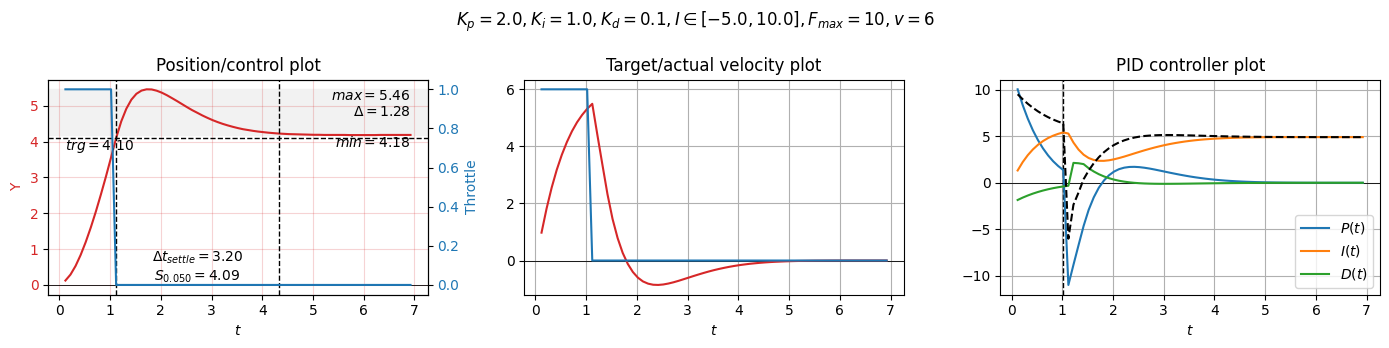

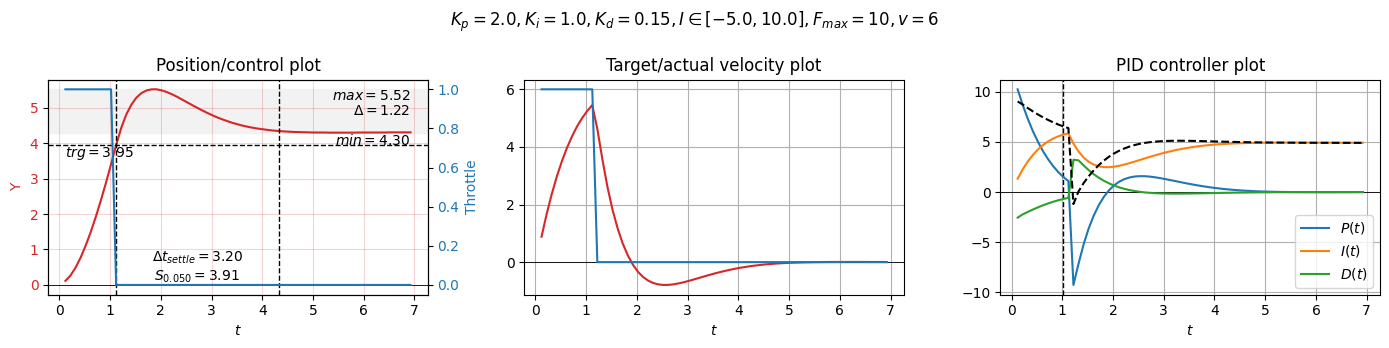

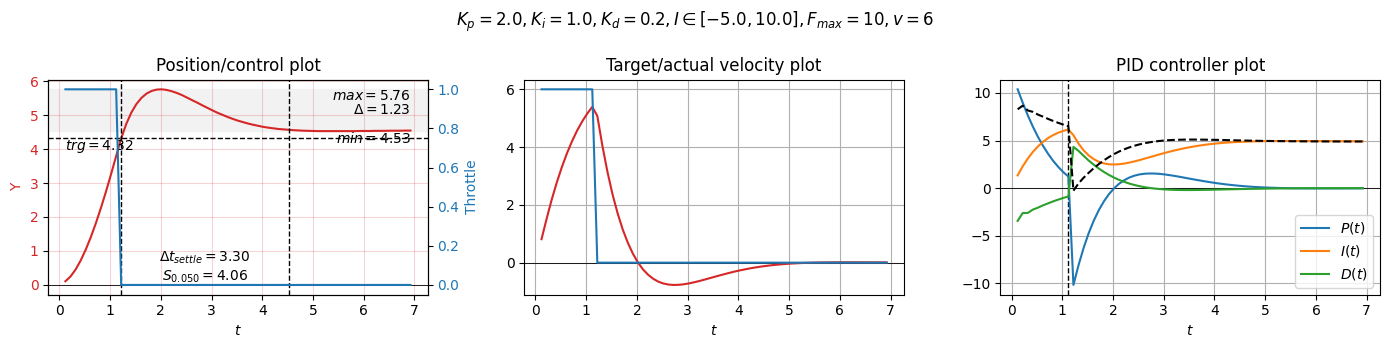

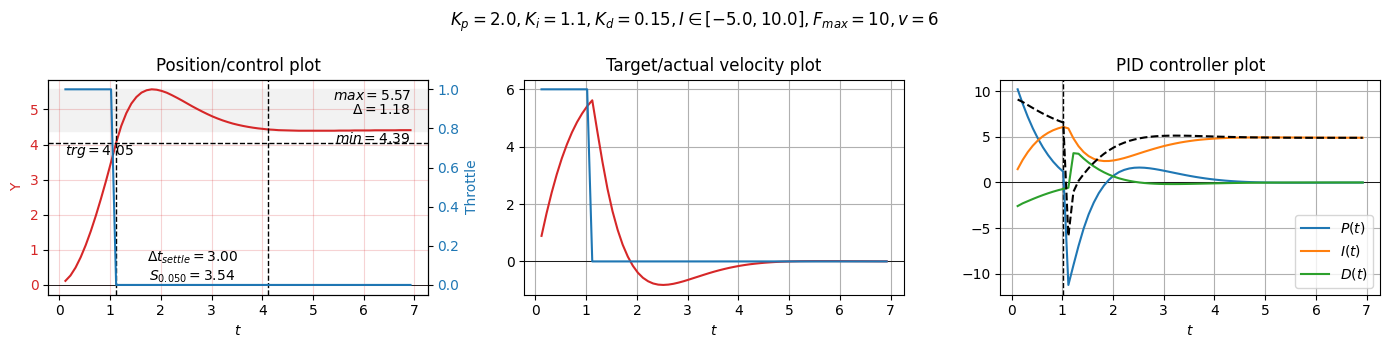

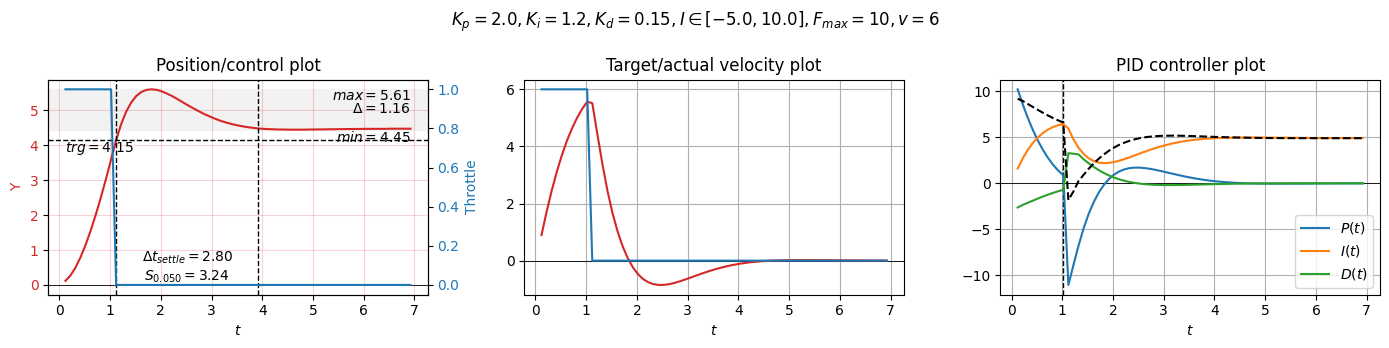

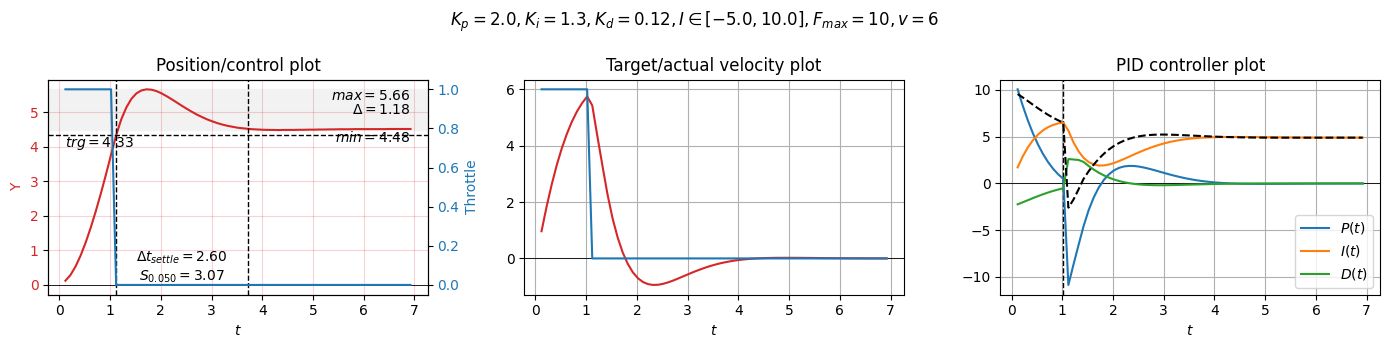

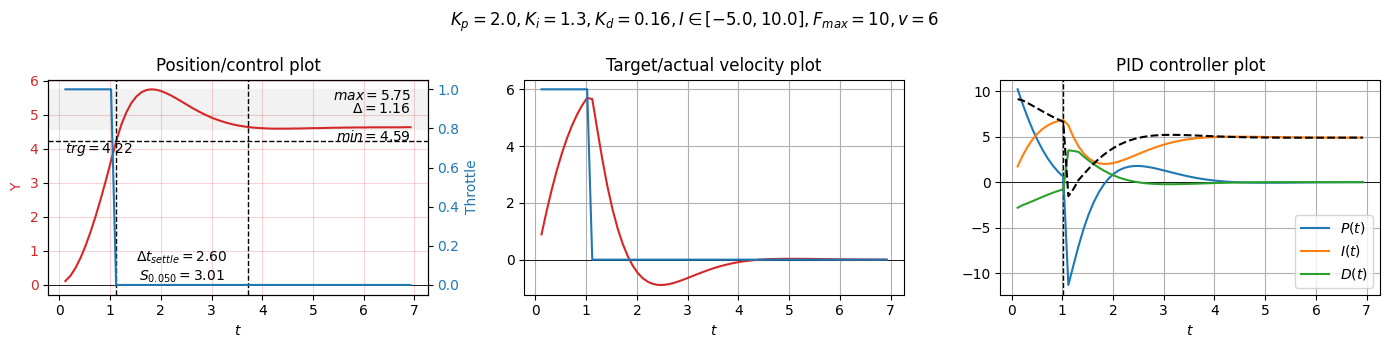

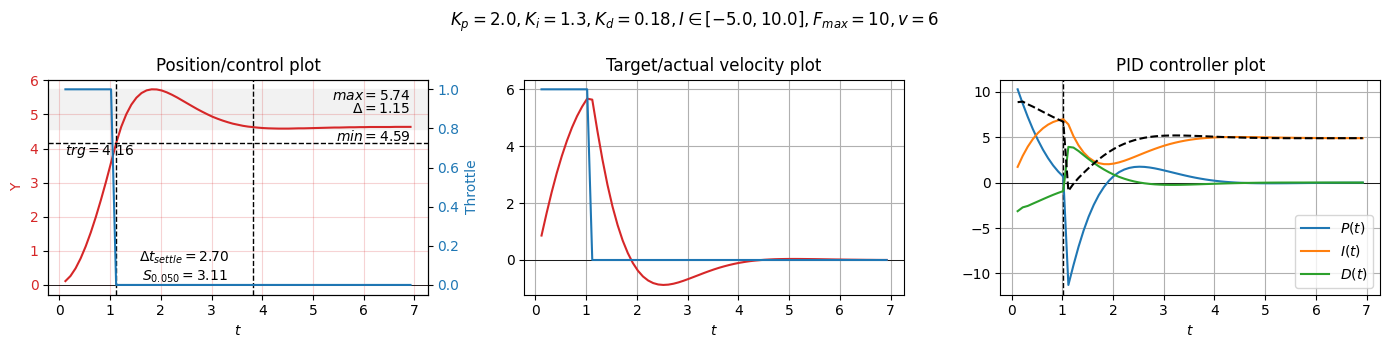

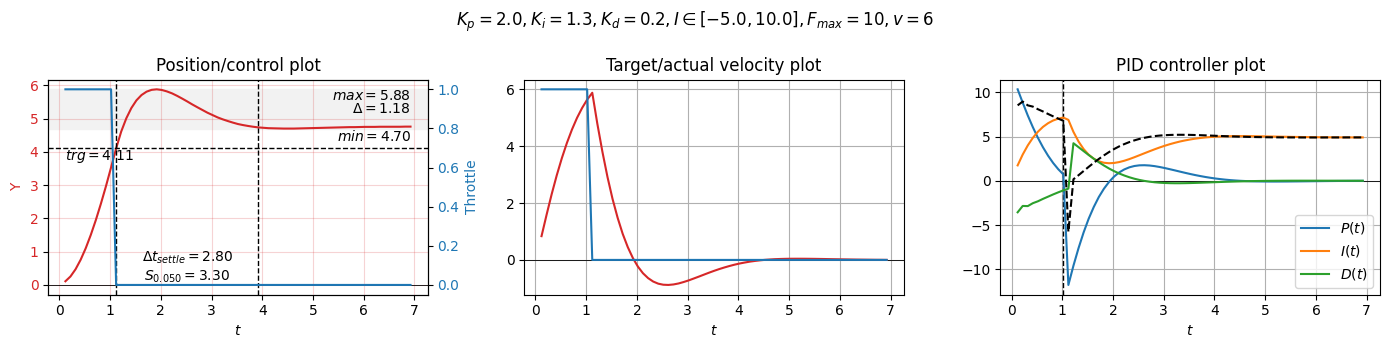

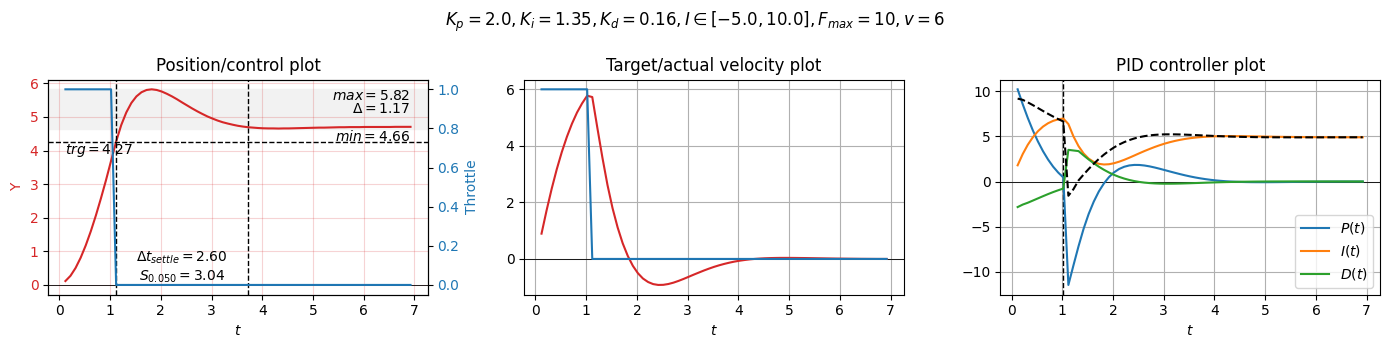

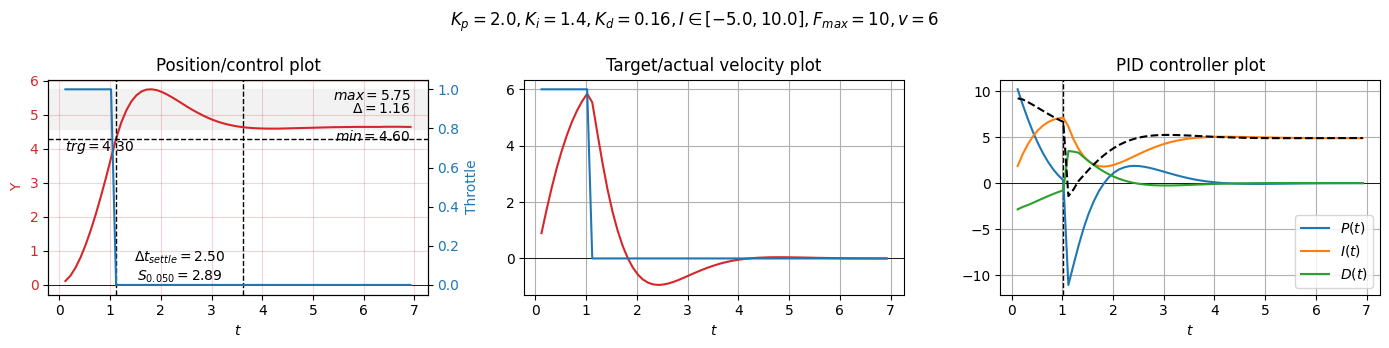

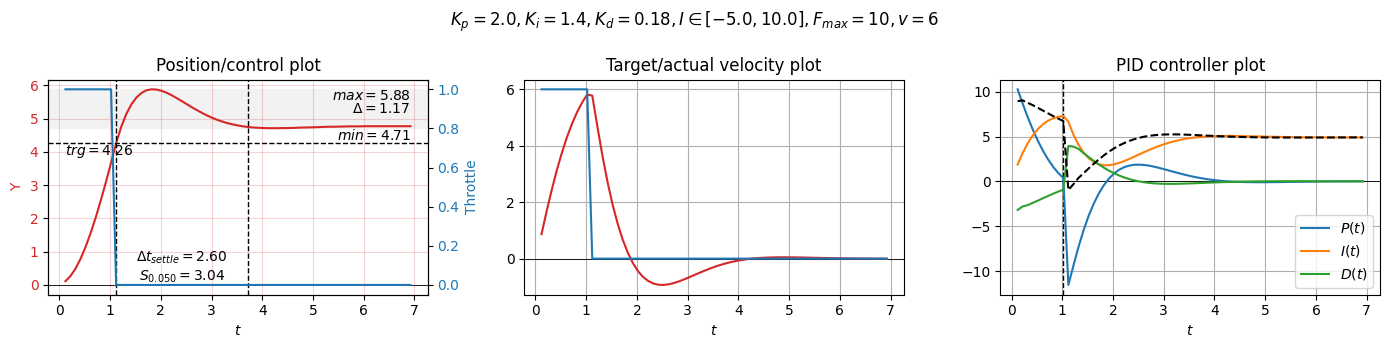

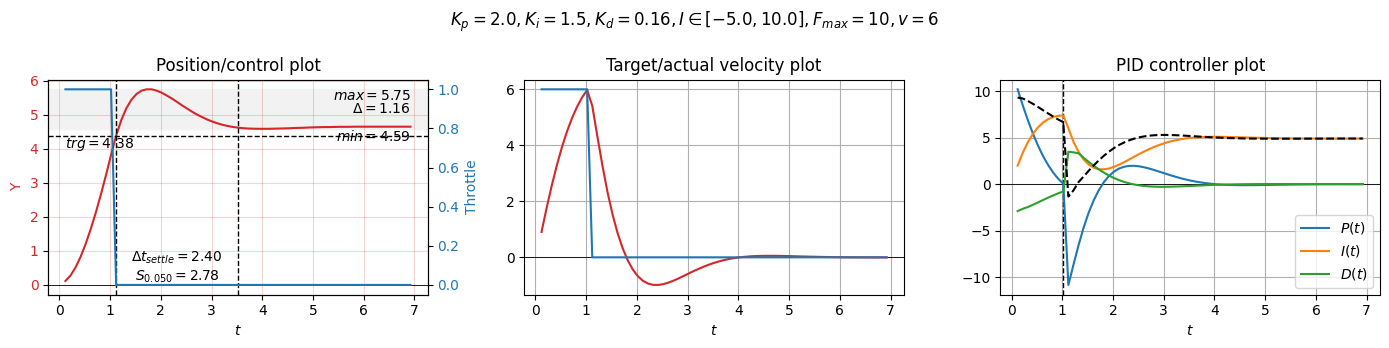

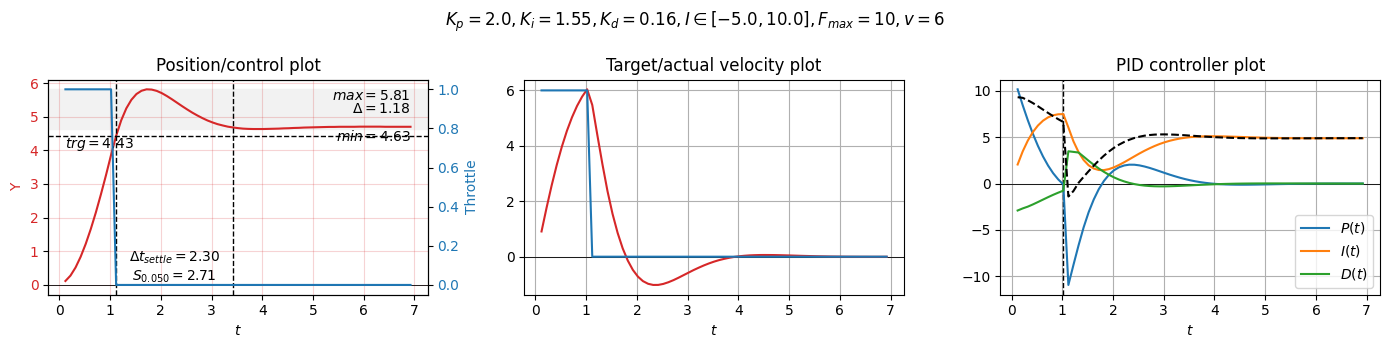

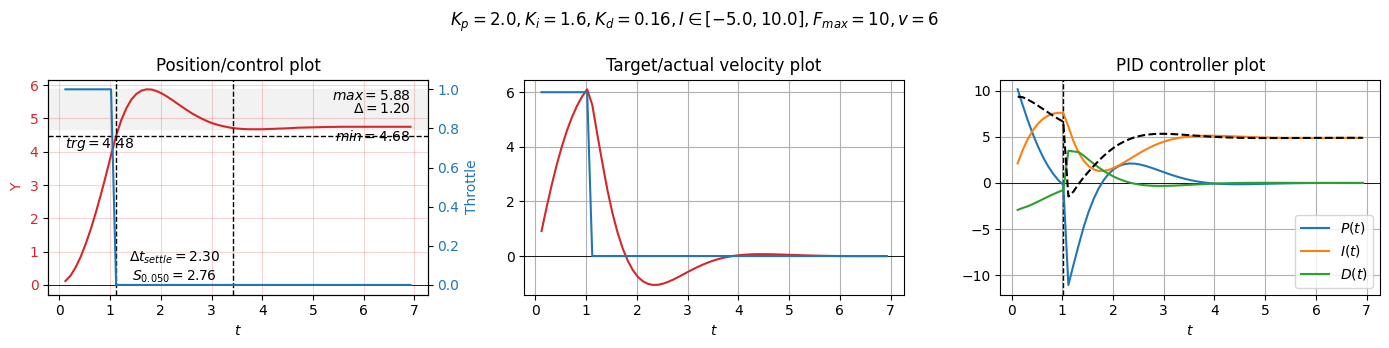

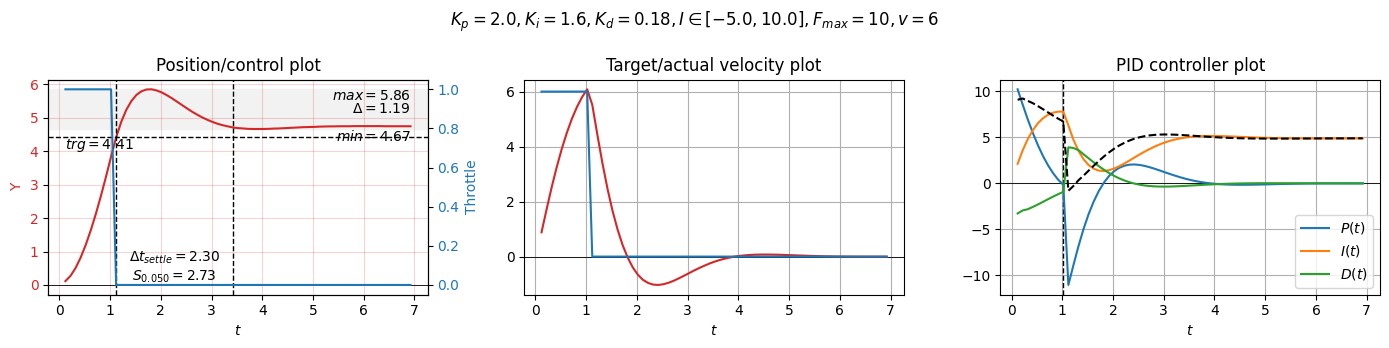

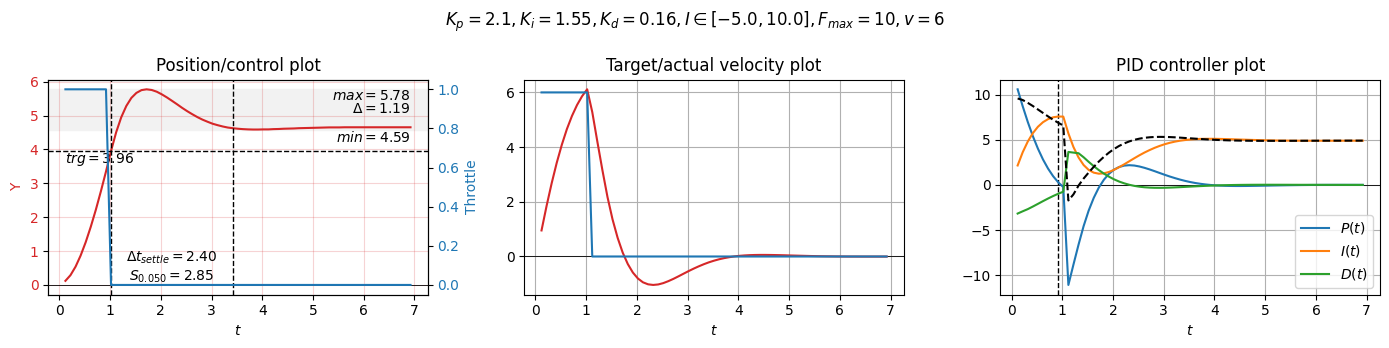

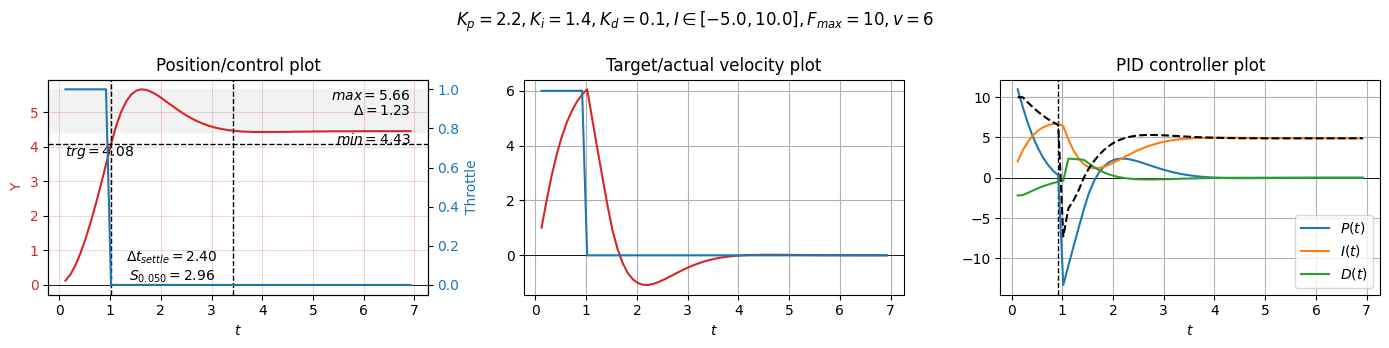

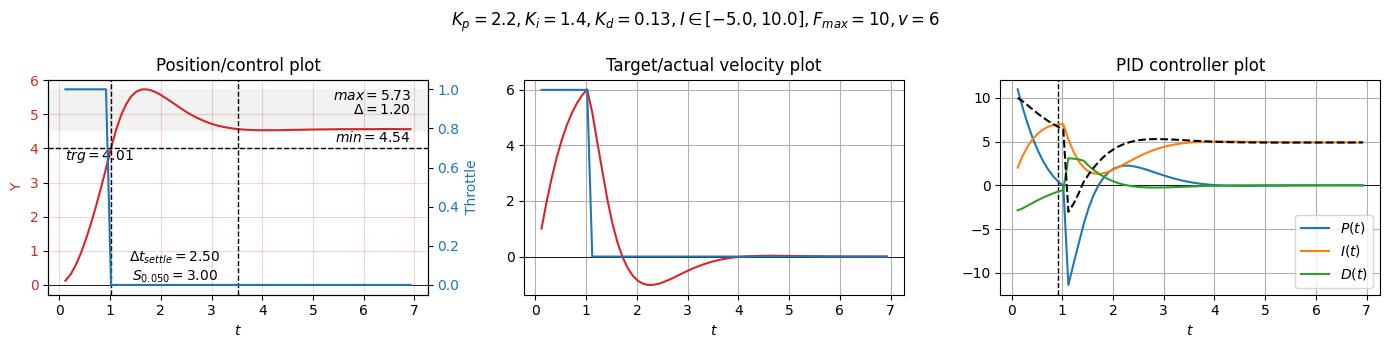

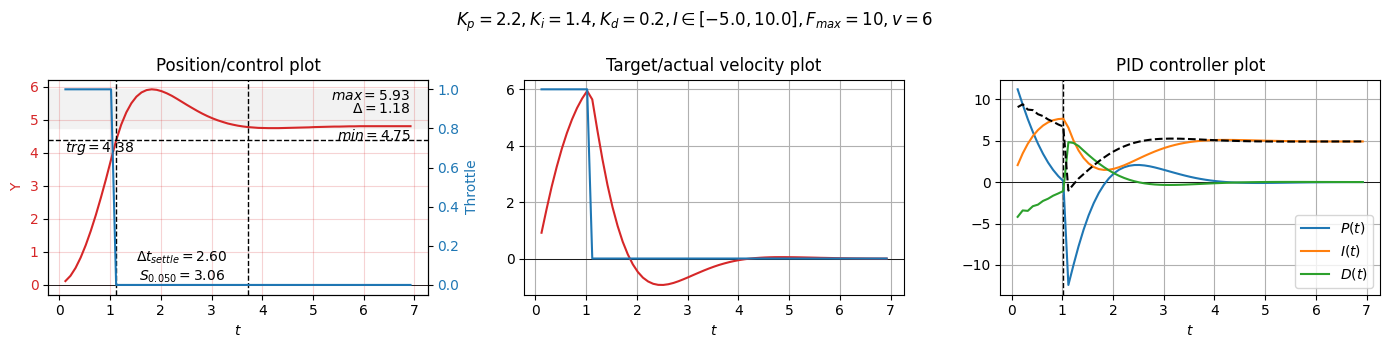

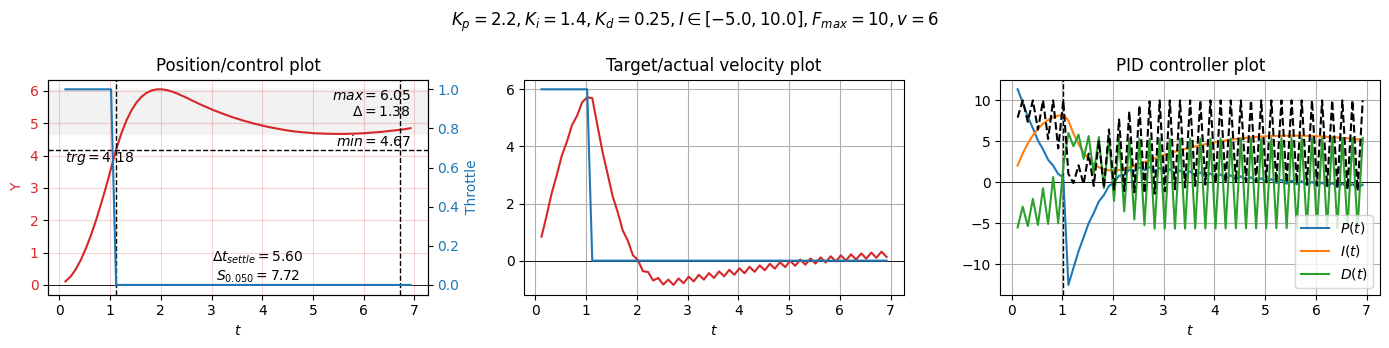

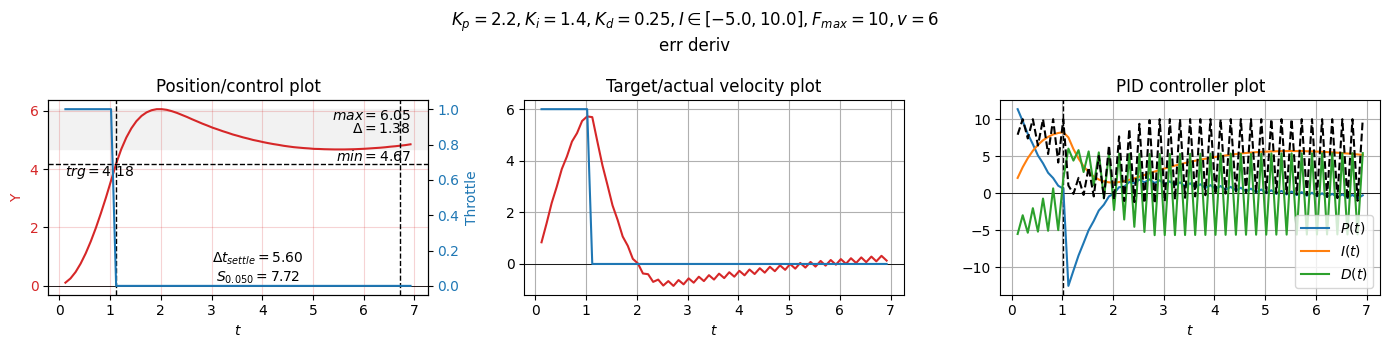

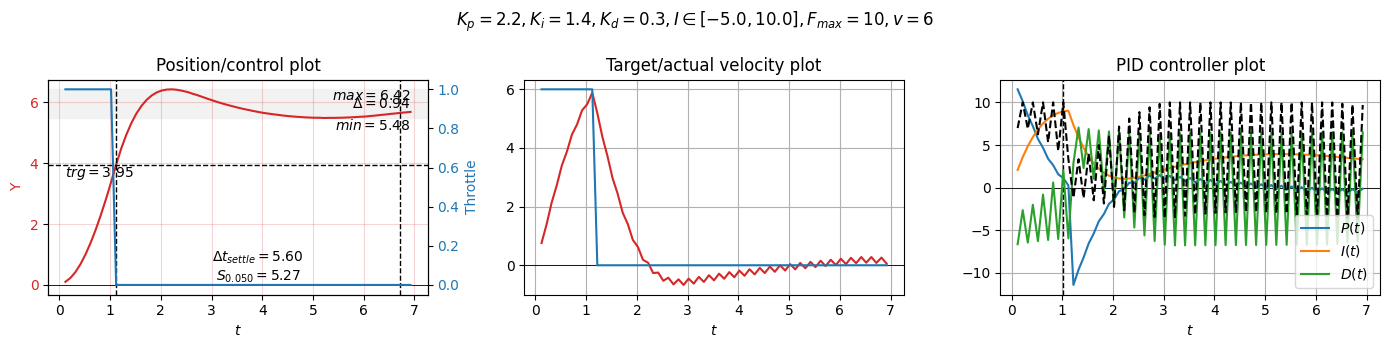

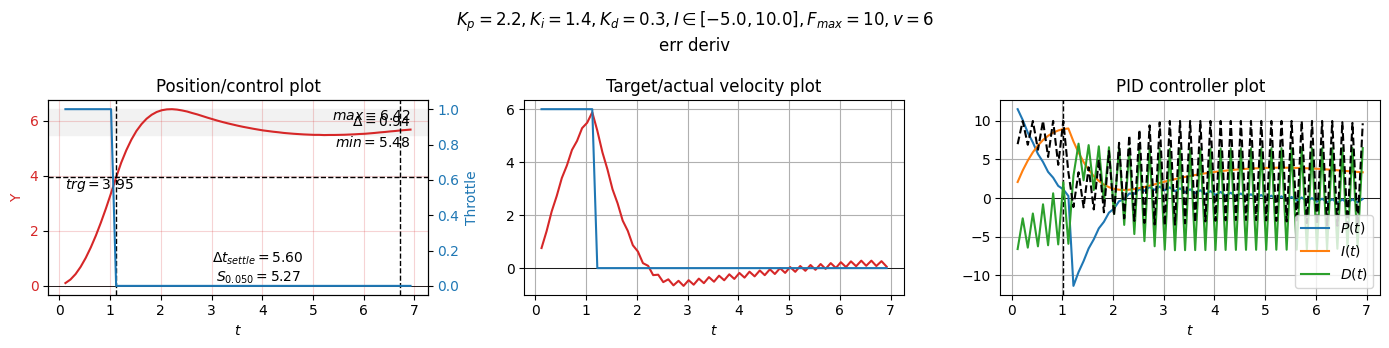

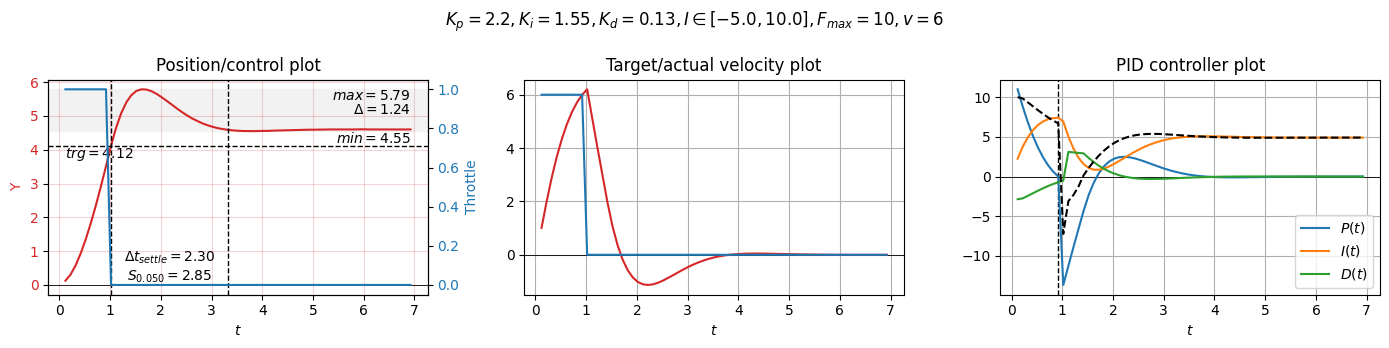

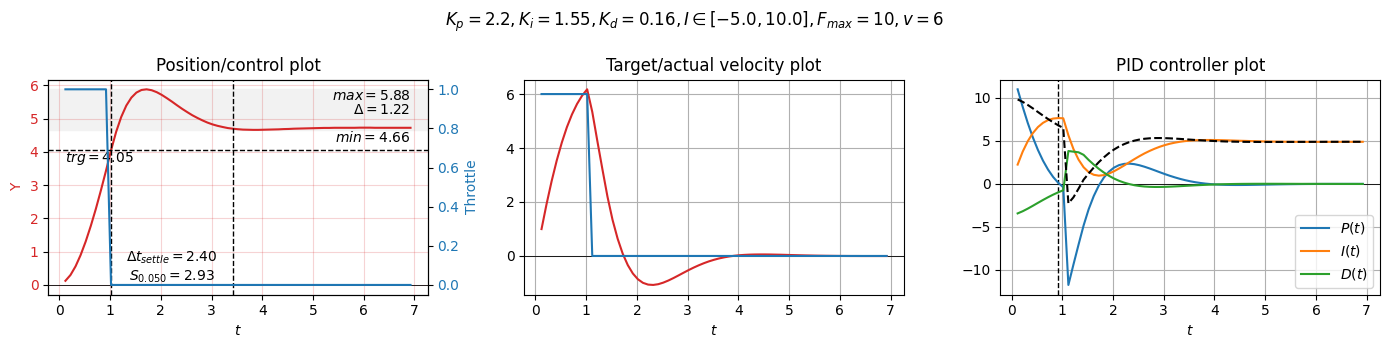

In [89]:
print_pid_and_movements(logs_path, figsize=(7, 3.5))